In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.integrate import cumulative_trapezoid
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
P0 = 100000.0
Lv = 2.501e6

# --- Thermodynamic Functions ---
def saturation_vapor_pressure(T):
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius)/(T_celsius + 243.5))
    return es_hPa * 100.0 # Pa

def saturation_specific_humidity(p, T):
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denom = p - (1.0 - epsilon) * es
    qs = np.divide(epsilon * es, denom, out=np.full_like(denom,1e-9), where=denom>0)
    return np.maximum(qs,1e-9)

def dqs_dT(p, T, dT=0.01):
    return (saturation_specific_humidity(p, T + dT)
          - saturation_specific_humidity(p, T - dT)) / (2*dT)

def dqs_dp(p, T, dp=10.0):
    return (saturation_specific_humidity(p + dp, T)
          - saturation_specific_humidity(p - dp, T)) / (2*dp)

def d2qs_dT2(p, T, dT=0.01):
    qs_p = saturation_specific_humidity(p, T + dT)
    qs_0 = saturation_specific_humidity(p, T)
    qs_m = saturation_specific_humidity(p, T - dT)
    return (qs_p - 2*qs_0 + qs_m) / (dT**2)

def d2qs_dTdp(p, T, dT=0.01, dp=10.0):
    dT_plus = dqs_dT(p + dp, T, dT)
    dT_minus = dqs_dT(p - dp, T, dT)
    return (dT_plus - dT_minus) / (2*dp)

def virtual_temperature(T, p):
    qs = saturation_specific_humidity(p, T)
    Tv = T * (1 + (1/epsilon - 1)*qs)
    return np.maximum(Tv,10.0)

def calculate_mse(T, p, z):
    qs = saturation_specific_humidity(p, T)
    return cpd * T + g * z + Lv * qs

def calculate_profile_with_rootfinder(T_surf, p_surf, p_grid):
    n = len(p_grid)
    T_prof = np.full(n, np.nan)
    z_prof = np.full(n, np.nan)
    T_prof[0], z_prof[0] = T_surf, 0.0
    mse0 = calculate_mse(T_surf, p_grid[0], 0.0)

    for i in range(n-1):
        T_cur, p_cur, z_cur = T_prof[i], p_grid[i], z_prof[i]
        p_next = p_grid[i+1]
        if np.isnan(T_cur) or p_cur <= 0:
            break
        Tv = virtual_temperature(T_cur, p_cur)
        dz = - (Rd * Tv / p_cur) / g * (p_next - p_cur)
        z_next = z_cur + dz

        def resid(Tg):
            return calculate_mse(Tg, p_next, z_next) - mse0
        
        try:
            br = [150.0, T_cur]
            if resid(br[0]) * resid(br[1]) > 0:
                break
            sol = root_scalar(resid, bracket=br, method='brentq', xtol=1e-3)
            if sol.converged:
                T_prof[i+1], z_prof[i+1] = sol.root, z_next
            else:
                break
        except (ValueError, RuntimeError):
            break
    return T_prof

print("--- Starting Main Calculation ---")
start_time = time.time()

# --- Grid setup ---
T_surf_values = np.arange(270, 320.1, 0.5)
p_surf_pa, p_top, dp = 100000.0, 10000.0, -50.0
p_grid = np.arange(p_surf_pa, p_top + dp, dp)
n_p, n_t = len(p_grid), len(T_surf_values)

# --- Storage for 2D fields ---
cL_grid = np.full((n_p, n_t), np.nan)
dGamma_m_dT_grid = np.full((n_p, n_t), np.nan)
dGamma_m_dTs_grid = np.full((n_p, n_t), np.nan)
warming_anomaly_grid = np.full((n_p, n_t), np.nan)

for j, Ts in enumerate(T_surf_values):
    print(f"Processing Ts = {Ts:.1f} K...")
    Tprof = calculate_profile_with_rootfinder(Ts, p_surf_pa, p_grid)
    cL_vals = Lv * dqs_dT(p_grid, Tprof)
    D = cpd + cL_vals
    dD_dT = Lv * d2qs_dT2(p_grid, Tprof)
    alpha_d = Rd * Tprof / p_grid
    alpha_L = -Lv * dqs_dp(p_grid, Tprof)
    N = alpha_d + alpha_L
    d_alpha_d_dT = Rd / p_grid
    d_alpha_L_dT = -Lv * d2qs_dTdp(p_grid, Tprof)
    dN_dT = d_alpha_d_dT + d_alpha_L_dT
    Term_A = (1.0 / D) * dN_dT
    Term_B = - (N / (D**2)) * dD_dT
    dGamma_m_dT_profile = Term_A + Term_B
    integral_term = cumulative_trapezoid(dGamma_m_dT_profile, x=p_grid, initial=0.0)
    exp_term = np.exp(integral_term)
    dGamma_m_dTs_profile = dGamma_m_dT_profile * exp_term
    integral_W = cumulative_trapezoid(dGamma_m_dTs_profile, x=p_grid, initial=0.0)
    W_anomaly_profile = integral_W
    cL_grid[:, j] = cL_vals
    dGamma_m_dT_grid[:, j] = dGamma_m_dT_profile
    dGamma_m_dTs_grid[:, j] = dGamma_m_dTs_profile
    warming_anomaly_grid[:, j] = W_anomaly_profile

print(f"\n--- Calculation Finished in {time.time() - start_time:.2f} seconds ---\n")

print("--- Processing Data for Figure 5 ---")
# --- Pre-calculate T_s gradients for finding extrema ---
dT_s = T_surf_values[1] - T_surf_values[0]
grad_dGamma_m_dT_grid = np.gradient(dGamma_m_dT_grid, dT_s, axis=1)
grad_dGamma_m_dTs_grid = np.gradient(dGamma_m_dTs_grid, dT_s, axis=1)
grad_warming_anomaly_grid = np.gradient(warming_anomaly_grid, dT_s, axis=1)
p_grid_hpa = p_grid / 100.0 # Dense y-axis for plotting
predicted_Ts_peak = np.full(n_p, np.nan)
actual_Ts_min_dT = np.full(n_p, np.nan)
actual_Ts_min_dTs = np.full(n_p, np.nan)
actual_Ts_max_W_anomaly = np.full(n_p, np.nan)

# --- Helper function for stable root interpolation ---
def find_interpolated_root(y_slice, x_vals, y_slice_for_guess=None, guess_mode='min'):
    if np.all(np.isnan(y_slice)):
        return np.nan
    
    # Find all sign changes
    sign_changes = np.where((y_slice[:-1] * y_slice[1:]) < 0)[0]

    # Filter for valid crossings
    k_all = []
    for k in sign_changes:
        if np.isfinite(y_slice[k]) and np.isfinite(y_slice[k+1]):
            k_all.append(k)
    if not k_all:
        return np.nan
    
    # Interpolate all candidate roots
    T_candidates = []
    for k in k_all:
        T0, T1 = x_vals[k], x_vals[k+1]
        y0, y1 = y_slice[k], y_slice[k+1]
        if y1 == y0: continue
        T_root = T0 - y0 * (T1 - T0) / (y1 - y0)
        T_candidates.append(T_root)
    if not T_candidates:
        return np.nan
    if len(T_candidates) == 1:
        return T_candidates[0]
    
    # If multiple roots, use the discrete min/max as a guess
    if y_slice_for_guess is None:
        y_slice_for_guess = y_slice
    if guess_mode == 'min':
        j_guess = np.nanargmin(y_slice_for_guess)
    elif guess_mode == 'max':
        j_guess = np.nanargmax(y_slice_for_guess)
    else: # 'abs_min'
        j_guess = np.nanargmin(np.abs(y_slice_for_guess))
    T_guess = x_vals[j_guess]

    # Return the candidate root closest to the discrete guess
    T_best = min(T_candidates, key=lambda T: abs(T - T_guess))
    return T_best

# Loop over every pressure level 'i' in the dense grid
for i in range(n_p):

    # --- 1. Find T_s for c_L = c_pd ---
    y_slice = cL_grid[i, :] - cpd
    predicted_Ts_peak[i] = find_interpolated_root(
        y_slice, T_surf_values, guess_mode='abs_min'
    )

    # --- 2. Find T_s for min(dGamma_m/dT) ---
    grad_slice = grad_dGamma_m_dT_grid[i, :]
    # Find root of gradient (neg->pos sign change)
    actual_Ts_min_dT[i] = find_interpolated_root(
        grad_slice, T_surf_values,
        y_slice_for_guess=dGamma_m_dT_grid[i, :],
        guess_mode='min'
    )
    
    # --- 3. Find T_s for min(dGamma_m/dTs) ---
    grad_slice = grad_dGamma_m_dTs_grid[i, :]
    # Find root of gradient (neg->pos sign change)
    actual_Ts_min_dTs[i] = find_interpolated_root(
        grad_slice, T_surf_values,
        y_slice_for_guess=dGamma_m_dTs_grid[i, :],
        guess_mode='min'
    )

    # --- 4. Find T_s for max(Warming Anomaly) ---
    grad_slice = grad_warming_anomaly_grid[i, :]
    # Find root of gradient (pos->neg sign change)
    actual_Ts_max_W_anomaly[i] = find_interpolated_root(
        grad_slice, T_surf_values,
        y_slice_for_guess=warming_anomaly_grid[i, :],
        guess_mode='max'
    )
    
# --- Post-processing fix ---
# Set 1000 hPa point (index 0) for warming anomaly to NaN
# p_grid[0] is 100000.0 Pa
actual_Ts_max_W_anomaly[0] = np.nan

--- Starting Main Calculation ---
Processing Ts = 270.0 K...
Processing Ts = 270.5 K...
Processing Ts = 271.0 K...
Processing Ts = 271.5 K...
Processing Ts = 272.0 K...
Processing Ts = 272.5 K...
Processing Ts = 273.0 K...
Processing Ts = 273.5 K...
Processing Ts = 274.0 K...
Processing Ts = 274.5 K...
Processing Ts = 275.0 K...
Processing Ts = 275.5 K...
Processing Ts = 276.0 K...
Processing Ts = 276.5 K...
Processing Ts = 277.0 K...
Processing Ts = 277.5 K...
Processing Ts = 278.0 K...
Processing Ts = 278.5 K...
Processing Ts = 279.0 K...
Processing Ts = 279.5 K...
Processing Ts = 280.0 K...
Processing Ts = 280.5 K...
Processing Ts = 281.0 K...
Processing Ts = 281.5 K...
Processing Ts = 282.0 K...
Processing Ts = 282.5 K...
Processing Ts = 283.0 K...
Processing Ts = 283.5 K...
Processing Ts = 284.0 K...
Processing Ts = 284.5 K...
Processing Ts = 285.0 K...
Processing Ts = 285.5 K...
Processing Ts = 286.0 K...
Processing Ts = 286.5 K...
Processing Ts = 287.0 K...
Processing Ts = 287.5

--- Generating Figure 5 ---


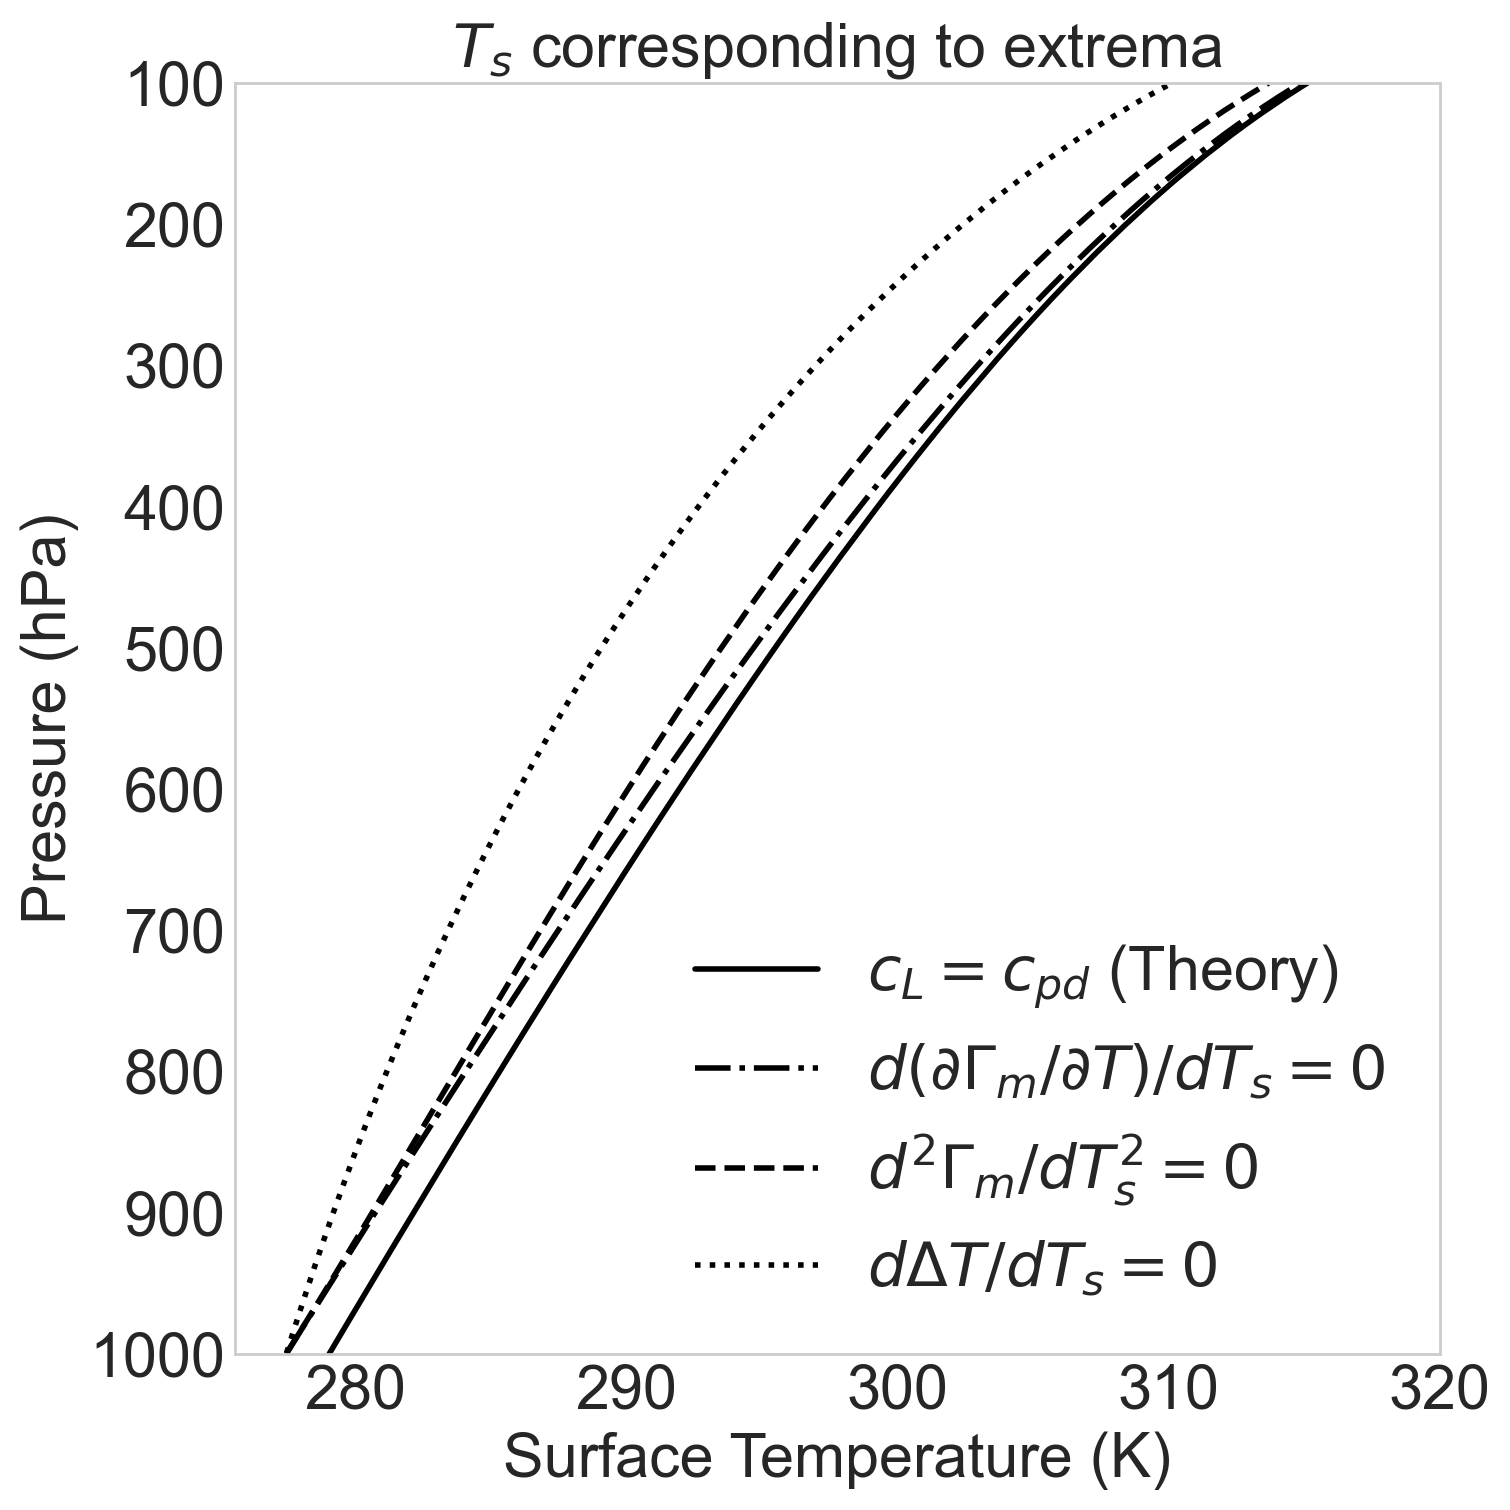

Figure 5 saved as fig-5.png

Script finished.


In [2]:
print("--- Generating Figure 5 ---")
plt.style.use('seaborn-v0_8-whitegrid')
base_fontsize = 22
plt.rcParams.update({
    'font.size': base_fontsize,
    'axes.titlesize': base_fontsize,
    'axes.labelsize': base_fontsize,
    'xtick.labelsize': base_fontsize,
    'ytick.labelsize': base_fontsize,
    'legend.fontsize': base_fontsize,
    'figure.titlesize': base_fontsize + 2
})
fig, ax = plt.subplots(figsize=(8, 8))

# --- Plot 1: Predicted T_s ---
ax.plot(predicted_Ts_peak, p_grid_hpa, '-', color='black', lw=2,
        label=r'$c_L = c_{pd}$ (Theory)')

# --- Plot 2: Actual T_s_min (local T derivative) ---
ax.plot(actual_Ts_min_dT, p_grid_hpa, '-.', color='black', lw=2,
        label=r'$d(\partial\Gamma_m/\partial T)/d {T_s} = 0$')

# --- Plot 3: Actual T_s_min (T_s derivative) ---
ax.plot(actual_Ts_min_dTs, p_grid_hpa, '--', color='black', lw=2,
        label=r'$d^2\Gamma_m/dT_s^2=0$')

# --- Plot 4: Actual T_s_max (Warming Anomaly) ---
ax.plot(actual_Ts_max_W_anomaly, p_grid_hpa, ':', color='black', lw=2,
        label=r'$d\Delta T/dT_s = 0$')

# Formatting
ax.set_xlabel('Surface Temperature (K)')
ax.set_ylabel('Pressure (hPa)')
ax.invert_yaxis()
ax.set_xlim(right=320)
ax.set_ylim(1000, 100)
p_levels_hpa = np.arange(100, 1001, 100)
ax.set_yticks(p_levels_hpa)
ax.set_title(r'$T_s$ corresponding to extrema')
ax.legend(loc='lower right')
ax.grid(False)
plt.tight_layout()
fig5_filename = "fig-5.png"
plt.savefig(fig5_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure 5 saved as {fig5_filename}")
print("\nScript finished.")


In [3]:
print(np.max(predicted_Ts_peak - actual_Ts_min_dT))
print(np.max(predicted_Ts_peak - actual_Ts_min_dTs))
print(np.nanmax(predicted_Ts_peak - actual_Ts_max_W_anomaly))

1.5842726793194402
2.0140403035097165
6.6203277879781695


In [4]:
print(p_grid_hpa[np.argmax(predicted_Ts_peak - actual_Ts_min_dT)])
print(p_grid_hpa[np.argmax(predicted_Ts_peak - actual_Ts_min_dTs)])
print(p_grid_hpa[np.nanargmax(predicted_Ts_peak - actual_Ts_max_W_anomaly)])

1000.0
419.5
382.0
